In [3]:
%load_ext autoreload
%autoreload 2

In [16]:
# Import the folium library.
import folium

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        show=show,
        opacity=opacity,
        min_zoom=min_zoom,
        overlay=True,
        control=True
        ).add_to(self)

# Add the Earth Engine layer method to folium.
folium.Map.add_ee_layer = add_ee_layer

# USE CASE
# map = folium.Map(location=[lat, lon], zoom_start=14)
# map.add_ee_layer(least_cloudy_image, {}, 'Normalized image')
# display(map)

# OR
# cropped_xarray.wx.rgb(bands=["SR_B4", "SR_B3", "SR_B2"], stretch=0.85, col_wrap=4)

In [17]:
import ee
import wxee

ee.Authenticate()

ee.Initialize()


Successfully saved authorization token.


## Install the mosaiks package

In [18]:
# Locally
# !pip install -e .. --upgrade

In [19]:
# From github
# 🚨 Make sure you update github token in the secrets file 🚨 
# import src.mosaiks.utils as utl
# mosaiks_package_link = utl.get_mosaiks_package_link
# !pip install {mosaiks_package_link} --upgrade

## Import packages

In [20]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [21]:
import sys
import os
import warnings

sys.path += ["../"]
warnings.filterwarnings("ignore")

In [22]:
import mosaiks.utils as utl
from mosaiks.featurize import *
from mosaiks.dask_run import *

# Setup Rasterio

In [23]:
rasterio_config = utl.load_yaml_config("rasterioc_config.yaml")
os.environ.update(rasterio_config)

# Setup Dask Cluster and Client

In [24]:
client = get_dask_client(kind="local")

INFO:root:http://127.0.0.1:65070/status


# Load params

In [25]:
featurization_config = utl.load_yaml_config("featurisation.yaml")
satellite_config = utl.load_yaml_config("satellite_config.yaml")
satellite_config = satellite_config[
    featurization_config["satellite_search_params"]["satellite_name"]
]

# Load point coords

In [26]:
request_points_gdf = utl.load_df_w_latlons_to_gdf(dataset_name=featurization_config["coord_set_name"])

In [27]:
points_gdf = request_points_gdf.sample(5, random_state=0) #.sample(200, random_state=0) # Select random 200 points (for testing)

## GEE Proof-of-Concept

In [32]:
# Set the location and buffer size
lat, lon  = points_gdf.iloc[1, :2]
buffer = 1200
search_start = '2013-04-01'
search_end = '2014-03-31'

point = ee.Geometry.Point(lon, lat)
crop = point.buffer(buffer).bounds()

collection = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(crop)
    .filterDate(search_start, search_end)
    .sort('CLOUD_COVER')
)
least_cloudy_image = collection.first()

xarray = least_cloudy_image.wx.to_xarray(region=crop, scale=30)
bands = satellite_config["bands"]
xarray = xarray[bands].to_array()
final_xarray = xarray.transpose("time", "variable", "y", "x").squeeze()

Downloading: 100%|██████████| 186k/186k [00:00<00:00, 547kiB/s] 


In [33]:
import torch
from mosaiks.featurize.stacs import minmax_normalize_image

image = final_xarray.values
torch_image = torch.from_numpy(image).float()
torch_image = minmax_normalize_image(torch_image)

In [34]:
from mosaiks.featurize.nn_forward_pass import featurize
model = RCF(
    featurization_config["num_features"],
    featurization_config["kernel_size"],
    len(satellite_config["bands"]),
)
features = featurize(torch_image, model, "cpu")
features[0]

array([0.        , 0.38922045, 0.        , ..., 0.38826618, 4.077604  ,
       0.01185514], dtype=float32)

## Setup Dask pipeline

In [35]:
points_dgdf = get_dask_gdf(points_gdf, featurization_config["dask"]["chunksize"])

INFO:root:500 points per partition results in 2 partitions.
INFO:root:Distributing 5 points across 500-point partitions results in 1 partitions.


In [36]:
if featurization_config["imagery_source"] == "GEE":
    partitions = points_dgdf.to_delayed()
elif featurization_config["imagery_source"] == "MPC":
    # need to fetch STACs for each point for MPC
    points_gdf_with_stac = fetch_image_refs(
        points_dgdf, featurization_config["satellite_search_params"]
    )
    partitions = points_gdf_with_stac.to_delayed()


In [37]:
model = RCF(
    featurization_config["num_features"],
    featurization_config["kernel_size"],
    len(satellite_config["bands"]),
)

# Run in parallel

## Trial run

8 simultaneous partitions seems to be about how many we can do in parallel on a local cluster. We may be able to do more on a Gateway Cluster once that is working.

TODO - CHANGE TO THIS SCHEME: There are also better schemes. For example, kick off another partitions whenever one finishes. That might be a better use of resources.

In [38]:
%%time
client.restart()
df = run_single_partition(
    partition=partitions[0], 
    satellite_config=satellite_config, 
    featurization_config=featurization_config, 
    model=model, 
    client=client
)

Downloading: 100%|██████████| 161k/161k [00:00<00:00, 393kiB/s] 
Downloading: 100%|██████████| 186k/186k [00:00<00:00, 444kiB/s] 
Downloading: 100%|██████████| 130k/130k [00:00<00:00, 359kiB/s] 
Downloading: 100%|██████████| 158k/158k [00:00<00:00, 387kiB/s] 
Downloading: 100%|██████████| 158k/158k [00:00<00:00, 389kiB/s] 


CPU times: user 2.2 s, sys: 540 ms, total: 2.74 s
Wall time: 27.5 s


Average feature value: 1.3696065427589437


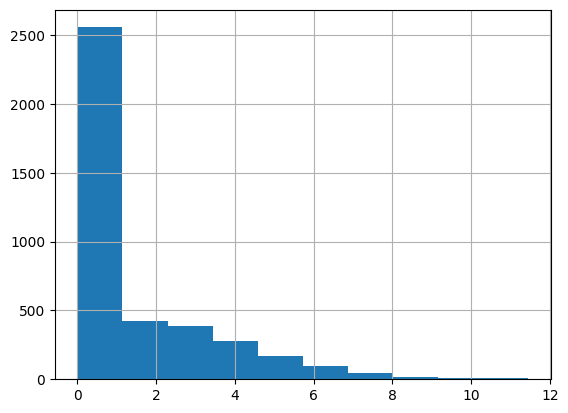

In [39]:
print("Average feature value:", df.mean().mean())
df.iloc[1].hist()
_ = client.restart()

Test multi-partition run

In [41]:
n_per_run = featurization_config["dask"]["n_per_run"]

failed_ids = run_partitions(
    partitions=partitions[:n_per_run],
    satellite_config=satellite_config,
    featurization_config=featurization_config,
    model=model,
    client=client,
    mosaiks_folder_path="test", #places files into "playground/test/"
    partition_ids=None,
)

INFO:root:Running 1 partitions...
INFO:root:n_partitions is smaller than n_per_run. Running all 1 partitions.
INFO:root:18-Apr 21:30:17 Running batch: 0 to 0
Downloading: 100%|██████████| 161k/161k [00:00<00:00, 410kiB/s] 
Downloading: 100%|██████████| 186k/186k [00:00<00:00, 428kiB/s] 
Downloading: 100%|██████████| 130k/130k [00:00<00:00, 361kiB/s] 
Downloading: 100%|██████████| 158k/158k [00:00<00:00, 388kiB/s] 
Downloading: 100%|██████████| 158k/158k [00:00<00:00, 399kiB/s] 


In [46]:
failed_ids

[]

In [45]:
utl.load_dataframe("./test/df_features_000.parquet.gzip")

,mosaiks_0,mosaiks_1,mosaiks_2,mosaiks_3,mosaiks_4,mosaiks_5,mosaiks_6,mosaiks_7,mosaiks_8,mosaiks_9,...,mosaiks_3990,mosaiks_3991,mosaiks_3992,mosaiks_3993,mosaiks_3994,mosaiks_3995,mosaiks_3996,mosaiks_3997,mosaiks_3998,mosaiks_3999
178377,0.628923,0.0,2.095599,0.000024,0.0,0.0,1.567544,0.001776,0.000133,0.0,...,1.366016,0.01393,0.773520,2.930562,1.147266,0.005764,0.024394,0.011586,1.114808,0.005275
167497,0.981828,0.0,2.171326,0.000000,0.0,0.0,2.297947,0.282649,0.000205,0.0,...,1.169873,0.00000,2.532082,2.539322,2.903116,0.000000,0.000000,0.000000,1.285883,0.000000
281910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226166,0.376054,0.0,3.174702,0.000000,0.0,0.0,2.723139,0.263828,0.000610,0.0,...,0.825116,0.00000,3.496540,3.462794,3.087507,0.000000,0.000000,0.000000,2.652125,0.000000
225184,1.528899,0.0,3.056922,0.000000,0.0,0.0,2.602498,0.004321,0.000098,0.0,...,1.415488,0.00000,0.806953,3.288050,1.463402,0.000000,0.000000,0.000000,0.851672,0.000182


## Full run

### Setup saving location

In [ ]:
mosaiks_folder_path = utl.make_features_path_from_dict(featurization_config, featurization_config["coord_set_name"])

### Create features and save checkpoints to file

In [ ]:
failed_partition_ids = run_partitions(
    partitions=partitions,
    satellite_config=satellite_config,
    featurization_config=featurization_config,
    model=model,
    client=client,
    mosaiks_folder_path=mosaiks_folder_path
)

## Re-run failed partitions

Use this to just run partitions that failed

In [ ]:
%%time

# subset to partitions that failed
failed_partitions = [partitions[i] for i in failed_partition_ids]

failed_partition_ids_1 = run_partitions(
    partitions=failed_partitions,
    partition_ids=failed_partition_ids,
    satellite_config=satellite_config,
    featurization_config=featurization_config,
    model=model,
    client=client,
    mosaiks_folder_path=mosaiks_folder_path,
)

failed_partition_ids_1

# Load checkpoint files and combine

In [ ]:
checkpoint_filenames = utl.get_filtered_filenames(
        folder_path=mosaiks_folder_path, prefix="df_"
    )

In [ ]:
combined_df = utl.load_and_combine_dataframes(
    folder_path=mosaiks_folder_path, filenames=checkpoint_filenames
)
combined_df = combined_df.join(points_gdf[["Lat", "Lon", "shrid"]])
logging.info("Dataset size in memory (MB):", combined_df.memory_usage().sum() / 1000000)

In [ ]:
%%time
combined_filename = "features.parquet.gzip"
combined_filepath = mosaiks_folder_path / combined_filename
utl.save_dataframe(
    df=combined_df, file_path=combined_filepath
)